In [3]:
import gensim
print(gensim.__version__)

3.6.0


In [4]:
#@title Imports
import numpy as np
import pandas as pd
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt

from keras import *
from keras.models import load_model
from keras.preprocessing.text import Tokenizer
from keras.preprocessing.sequence import pad_sequences
from keras.layers import *
from keras.callbacks import EarlyStopping, ModelCheckpoint
from keras.losses import BinaryCrossentropy
from keras.optimizers import adam_v2
from keras.utils.vis_utils import plot_model
from keras.initializers import Constant

from keras_tuner import * 

In [6]:
# load dataframe, delete article link column
pd.set_option('display.max_colwidth', None)
# there are v1 and v2
file_name = 'Sarcasm_Headlines_Dataset.json'
df = pd.read_json(file_name, lines=True)
del df['article_link']
df.head(5)

,headline,is_sarcastic
0,former versace store clerk sues over secret 'black code' for minority shoppers,0
1,"the 'roseanne' revival catches up to our thorny political mood, for better and worse",0
2,mom starting to fear son's web series closest thing she will have to grandchild,1
3,"boehner just wants wife to listen, not come up with alternative debt-reduction ideas",1
4,j.k. rowling wishes snape happy birthday in the most magical way,0


# Preprocessing

## Data cleaning

In [7]:
appos = {
        "aren't": "are not", "can't": "cannot", "couldn't": "could not", "didn't": "did not", "doesn't": "does not", "don't": "do not",
        "hadn't": "had not", "hasn't": "has not", "haven't": "have not", "he'd": "he had", "he'll": "he will", "he's": "he is",
        "I'd": "I had", "I'll": "I will", "I'm": "I am", "I've": "I have", "isn't": "is not", "let's": "let us", "mightn't": "might not",
        "mustn't": "must not", "shan't": "shall not", "she'd": "she had", "she'll": "she will", "she's": "she is", "shouldn't": "should not",
        "what's": "what is", "there's": "there is", "they'd": "they had", "they'll": "they will", "they've": "they have",
        "we'd": "we had", "we're": "we are", "we've": "we have", "weren't": "were not",
}
def transform_appos(headline):
    arr = []
    for row in headline.values:
        for word in row:
            if word in appos.keys():
                row = row.replace(word, appos[word])
    return headline

def to_lowercase(headline):
    headline = headline.apply(lambda x: x.lower())
    return headline

def remove_whitespaces(headline):
    headline = headline.str.strip()
    return headline

def replace_quote(headline):
    headline = headline.str.replace("’", "'")
    return headline

def preprocess(headlines: pd.Series):
    headlines = to_lowercase(headlines)
    headlines = replace_quote(headlines)
    headlines = transform_appos(headlines)
    return headlines

# apply preprocessing to the whole dataset
df['headline'] = preprocess(df['headline'])

In [8]:
# split data into train and test set into 60:20:20
train_df, test_df = train_test_split(df, train_size=0.6, shuffle=True, random_state=0)
val_df, test_df = train_test_split(test_df, train_size=0.5, shuffle=True, random_state=0)

# separate data from labels
x_train, y_train = train_df['headline'], train_df['is_sarcastic']
x_test, y_test = test_df['headline'], test_df['is_sarcastic']
x_val, y_val = val_df['headline'], val_df['is_sarcastic']

## Gensim preprocessing

In [9]:
# Gensim preprocessing
import gensim
from gensim.utils import simple_preprocess

sentences = [simple_preprocess(sentence) for sentence in x_train]
# look at format needed for gensim
print(x_train[:2])
print(sentences[:2])

17847    bernice king says trump's racist comments are 'troubling to our humanity'
2261                                             world's most innovative companies
Name: headline, dtype: object
[['bernice', 'king', 'says', 'trump', 'racist', 'comments', 'are', 'troubling', 'to', 'our', 'humanity'], ['world', 'most', 'innovative', 'companies']]


## TF preprocessing - tokenization, padding, truncation

In [10]:
# tokenization, padding, truncation
vocab_size = len(gensim.models.Word2Vec(sentences).wv.vocab) + 1 # +1 for oov token
oov_token = '<OOV>'
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

In [11]:
# find longest tokenized sequence in order to optimize padding and truncation
find_longest_seq = lambda dataset: max([len(seq) for seq in tokenizer.texts_to_sequences(dataset)])
longest_seq = max(find_longest_seq(x_train), find_longest_seq(x_test), find_longest_seq(x_val))
longest_seq

40

In [12]:
# longest_seq is 40 -> MAXLEN of matrices will be 64
MAXLEN = 64

In [13]:
# tokenization, padding, truncation
tokenizer = Tokenizer(num_words=vocab_size, oov_token=oov_token)
tokenizer.fit_on_texts(x_train)
word_index = tokenizer.word_index

train_sequences = tokenizer.texts_to_sequences(x_train)
train_padded = pad_sequences(train_sequences, padding='post', truncating='post', maxlen=MAXLEN)

test_sequences = tokenizer.texts_to_sequences(x_test)
test_padded = pad_sequences(test_sequences, padding='post', truncating='post', maxlen=MAXLEN)

val_sequences = tokenizer.texts_to_sequences(x_val)
val_padded = pad_sequences(val_sequences, padding='post', truncating='post', maxlen=MAXLEN)

# Need this block to get it to work with TensorFlow 2.x
x_train = np.array(train_padded)
x_test = np.array(test_padded)
x_val = np.array(val_padded)
y_train = np.array(y_train)
y_test = np.array(y_test)
y_val = np.array(y_val)

# Load pretrained embeddings

In [14]:
# download pretrained embeddings
import gensim.downloader as api
glove_vectors = api.load('glove-twitter-200')

[==================================================] 100.0% 758.5/758.5MB downloaded


In [15]:
# load weights, vocab size, embedding size
glove_weights = glove_vectors.vectors
glove_vocab_size, glove_embedding_size = glove_weights.shape

# create embedding layer from glove
embedding_layer = Embedding(input_dim=glove_vocab_size, 
                            output_dim=glove_embedding_size)
embedding_layer.build(input_shape=(glove_vocab_size,))
embedding_layer.set_weights([glove_weights])
embedding_layer.trainable = False

In [16]:
# show embedding config
print(embedding_layer.get_config())

# to prove that weights in embedding layer are appropriately initialized,
# compare glove weights with embedding weights
print((glove_weights == embedding_layer.get_weights()).all())

# look at some embedding weights
# print(glove_weights[:2])

{'name': 'embedding', 'trainable': False, 'batch_input_shape': (None, None), 'dtype': 'float32', 'input_dim': 1193514, 'output_dim': 200, 'embeddings_initializer': {'class_name': 'RandomUniform', 'config': {'minval': -0.05, 'maxval': 0.05, 'seed': None}}, 'embeddings_regularizer': None, 'activity_regularizer': None, 'embeddings_constraint': None, 'mask_zero': False, 'input_length': None}
True


# Train a model

## Fixed embedding - no embedding update during training 

In [17]:
# Callbacks
stop_early = EarlyStopping(monitor='val_loss', patience=4)
save_best_weights = ModelCheckpoint('checkpoints/rnn', 
                                    monitor='val_loss',
                                    save_best_only=True,
                                    save_weights_only=True)

In [18]:
def model_builder() -> Model:
    glove_weights = glove_vectors.vectors
    glove_vocab_size, glove_embedding_size = glove_weights.shape

    # https://github.com/keras-team/keras/issues/4753#issuecomment-629618860
    embedding_layer = Embedding(input_dim=glove_vocab_size, output_dim=glove_embedding_size)
    embedding_layer.build(input_shape=(glove_vocab_size,))
    embedding_layer.set_weights([glove_weights])
    embedding_layer.trainable = False

    model = Sequential([
        embedding_layer,
        # GlobalAveragePooling1D(),
        Conv1D(128, 5, activation="relu"),
        MaxPool1D(5),
        Conv1D(128, 5, activation="relu"),
        Dropout(0.1),
        Bidirectional(GRU(units=512, 
                       dropout=0.1,
                       # need return_sequences when chaining multiple bidirectional grus
                       return_sequences=True),
                       name='gru'),
        Bidirectional(GRU(units=512, 
                       dropout=0.1),
                      name='gru2'),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])

    optimizer = adam_v2.Adam(0.0007)
    loss = BinaryCrossentropy()
    metrics=['accuracy']
    model.compile(optimizer, loss, metrics)
    return model

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 embedding_1 (Embedding)     (None, None, 200)         238702800 
                                                                 
 conv1d (Conv1D)             (None, None, 128)         128128    
                                                                 
 max_pooling1d (MaxPooling1D  (None, None, 128)        0         
 )                                                               
                                                                 
 conv1d_1 (Conv1D)           (None, None, 128)         82048     
                                                                 
 dropout (Dropout)           (None, None, 128)         0         
                                                                 
 gru (Bidirectional)         (None, None, 1024)        1972224   
                                                        

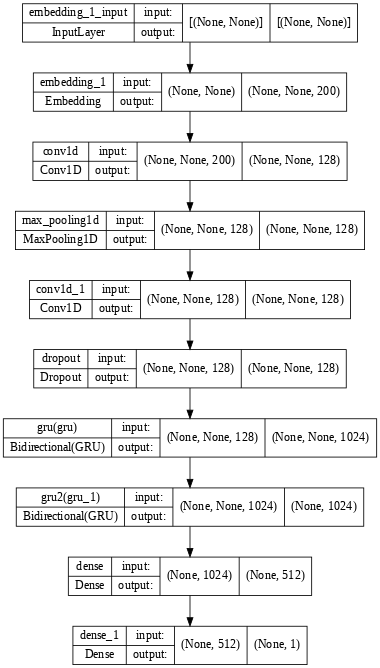

In [19]:
model = model_builder()
model.summary()
plot_model(model, show_shapes=True,dpi=60)

In [20]:
history = model.fit(x_train,
        y_train,
        batch_size=128,
        epochs=15,
        validation_data=[x_val, y_val],
        callbacks=[stop_early],
        verbose=2)

Epoch 1/15
126/126 - 29s - loss: 0.6313 - accuracy: 0.6260 - val_loss: 0.5411 - val_accuracy: 0.7168 - 29s/epoch - 226ms/step
Epoch 2/15
126/126 - 7s - loss: 0.4651 - accuracy: 0.7762 - val_loss: 0.4941 - val_accuracy: 0.7445 - 7s/epoch - 52ms/step
Epoch 3/15
126/126 - 7s - loss: 0.3210 - accuracy: 0.8622 - val_loss: 0.5327 - val_accuracy: 0.7630 - 7s/epoch - 52ms/step
Epoch 4/15
126/126 - 7s - loss: 0.1954 - accuracy: 0.9210 - val_loss: 0.6708 - val_accuracy: 0.7587 - 7s/epoch - 52ms/step
Epoch 5/15
126/126 - 7s - loss: 0.1284 - accuracy: 0.9501 - val_loss: 0.7517 - val_accuracy: 0.7537 - 7s/epoch - 52ms/step
Epoch 6/15
126/126 - 7s - loss: 0.0856 - accuracy: 0.9667 - val_loss: 0.9368 - val_accuracy: 0.7570 - 7s/epoch - 52ms/step


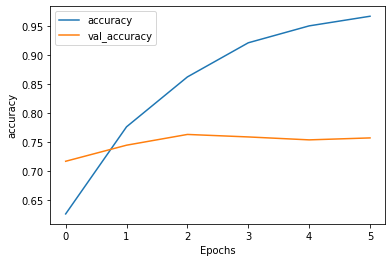

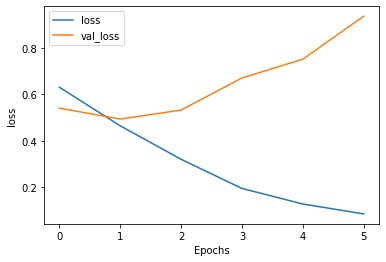

In [21]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

## Trainble embedding

In [22]:
def model_builder2() -> Model:
    glove_weights = glove_vectors.vectors
    glove_vocab_size, glove_embedding_size = glove_weights.shape
    embedding_layer = Embedding(input_dim=glove_vocab_size, 
                                output_dim=glove_embedding_size,
                                embeddings_initializer=Constant(glove_weights),
                                trainable=True)

    model = Sequential([
        embedding_layer,
        Conv1D(128, 5, activation="relu"),
        MaxPool1D(5),
        Conv1D(128, 5, activation="relu"),
        Dropout(0.1),
        Bidirectional(GRU(units=512, 
                       dropout=0.1,
                       # need return_sequences when chaining multiple bidirectional grus
                       return_sequences=True),
                       name='gru'),
        Bidirectional(GRU(units=512, 
                       dropout=0.1),
                      name='gru2'),
        Dense(512, activation='relu'),
        Dense(1, activation='sigmoid')
    ])
    optimizer = adam_v2.Adam(0.0006)
    loss = BinaryCrossentropy()
    metrics=['accuracy']
    model.compile(optimizer, loss, metrics)
    return model

In [23]:
model2 = model_builder2()
history = model2.fit(x_train,
        y_train,
        batch_size=64,
        epochs=15,
        validation_data=[x_val, y_val],
        callbacks=[stop_early, save_best_weights],
        verbose=2)

Epoch 1/15
251/251 - 73s - loss: 0.5634 - accuracy: 0.6989 - val_loss: 0.4537 - val_accuracy: 0.7812 - 73s/epoch - 290ms/step
Epoch 2/15
251/251 - 61s - loss: 0.3270 - accuracy: 0.8603 - val_loss: 0.4157 - val_accuracy: 0.8128 - 61s/epoch - 244ms/step
Epoch 3/15
251/251 - 52s - loss: 0.1772 - accuracy: 0.9327 - val_loss: 0.4899 - val_accuracy: 0.8160 - 52s/epoch - 207ms/step
Epoch 4/15
251/251 - 52s - loss: 0.0870 - accuracy: 0.9676 - val_loss: 0.6271 - val_accuracy: 0.8139 - 52s/epoch - 207ms/step
Epoch 5/15
251/251 - 52s - loss: 0.0662 - accuracy: 0.9769 - val_loss: 0.7195 - val_accuracy: 0.8145 - 52s/epoch - 207ms/step
Epoch 6/15
251/251 - 52s - loss: 0.0442 - accuracy: 0.9846 - val_loss: 0.8079 - val_accuracy: 0.8053 - 52s/epoch - 207ms/step


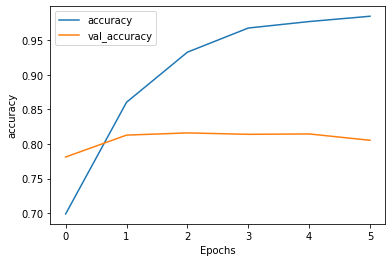

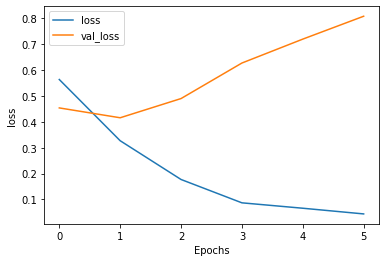

In [24]:
def plot_graphs(history, string):
  plt.plot(history.history[string])
  plt.plot(history.history['val_' + string])
  plt.xlabel("Epochs")
  plt.ylabel(string)
  plt.legend([string, 'val_' + string])
  plt.show()
  
plot_graphs(history, "accuracy")
plot_graphs(history, "loss")

In [27]:
# load best model's weights
saved_model = model_builder2()
saved_model.load_weights('checkpoints/rnn')
loss, acc = saved_model.evaluate(x_test, y_test, batch_size=64, verbose=0)
print(f'Loss is: {loss} \nAcc is: {acc} \n')

# f1 score
y_pred = (model.predict(x_test) > 0.5).astype('int32')
print(classification_report(y_test, y_pred))

Loss is: 0.42241811752319336 
Acc is: 0.8202919960021973 

              precision    recall  f1-score   support

           0       0.77      0.81      0.79      3014
           1       0.74      0.69      0.71      2328

    accuracy                           0.76      5342
   macro avg       0.75      0.75      0.75      5342
weighted avg       0.76      0.76      0.76      5342

